In [ ]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

In [2]:
 #load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.python.keras.backend as K

'''
build a custom layer using Keras, integrating BERT from tf-hub,
we could also fine tune the BERT model, for example: only subset of pre-trained BERT layers
'''
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layer=12, bert_path='https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1', **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layer
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(self.bert_path, trainable=self.trainable, name="{}_module".format(self.name))
        trainable_vars = self.bert.variables
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers:]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        # Add non_trainable weights:
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs] #cast the variables to int32 tensor
        input_ids, input_mask, segment_ids, valid_positions = inputs
        ## we don't feed the valid_position into the model, the valid_position is only used for the slots transform to align to the tokenized input
        bert_inputs = dict(input_ids=input_ids, ## we can use 'convert_tokens_to_ids' function to get the ids from tokens
                           input_mask=input_mask,
                           segment_ids=segment_ids)
        result = self.bert(inputs=bert_inputs, signature='tokens', as_dict=True)
        return result['pooled_output'], result['sequence_output']

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_size)


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

class NLUModel:

    def __init__(self):
        self.model = None

    def visualize_metric(self, history_dic, metric_name):
        plt.plot(history_dic[metric_name])
        legend = ['train']
        if 'val_' + metric_name in history_dic:
            plt.plot(history_dic['val_'+metric_name])
            legend.append('test')
        plt.title('model_' + metric_name)
        plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(legend, loc='upper left')
        plt.show()

    def predict(self, x):
        return self.model.predict(x)

    def save(self, model_path):
        self.model.save(model_path)

    def load(model_path, custom_objects=None):
        new_model = NLUModel()
        new_model.model = load_model(model_path, custom_objects=custom_objects)
        return new_model

    def predict_slots_intent(self, x, slots_tokenizer, intents_label_encoder):
        if len(x.shape) == 1:
            x = x[np.newaxis, ...]

        y1, y2 = self.predict(x)
        intents = np.array([intents_label_encoder.inverse_transform([np.argmax(y2[i])])[0] for i in range(y2.shape[0])])
        slots = []
        for i in range(y1.shape[0]):
            y = [np.argmax(i) for i in y1[i]]
            slot = []
            for i in y:
                if i == 0:
                    slot.append('o')
                else:
                    slot.append(slots_tokenizer.index_word[i])
            slots.append(slot[:len(x[i])+1])
        return intents, slots

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

'''
By using LabelEncoder to create the labelencoder of slot-tags
'''
class TagsVectorizer:

    def __init__(self):
        pass

    def tokenize(self, tags_str_arr):
        return [s.split() for s in tags_str_arr]

    def fit(self, train_tags_str_arr, val_tags_str_arr):
        ## in order to avoid, in valid_dataset, there is tags which not exit in train_dataset. like: ATIS datset
        self.label_encoder = LabelEncoder()
        data = ["[padding]", "[CLS]", "[SEP]"] + [item for sublist in self.tokenize(train_tags_str_arr) for item in sublist]
        data = data + [item for sublist in self.tokenize(val_tags_str_arr) for item in sublist]
        ## # data:  ["[padding]", "[CLS]", "[SEP]", all of the real tags]; add the "[padding]", "[CLS]", "[SEP]" for the real tag list
        self.label_encoder.fit(data)

    def transform(self, tags_str_arr, valid_positions):
        ## if we set the maximum length is 50, then the seq_length is 50; otherwise, it will be equal to the maximal length of dataset
        seq_length = valid_positions.shape[1] # .shape[0]: number of rows, .shape[1]: number of columns
        data = self.tokenize(tags_str_arr)
        ## we added the 'CLS' and 'SEP' token as the first and last token for every sentence respectively
        data = [self.label_encoder.transform(["[CLS]"] + x + ["[SEP]"]).astype(np.int32) for x in data] #upper 'O', not 0

        output = np.zeros((len(data), seq_length))
        for i in range(len(data)):
            idx = 0
            for j in range(seq_length):
                if valid_positions[i][j] == 1:
                    output[i][j] = data[i][idx]
                    idx += 1
        return output

    def inverse_transform(self, model_output_3d, valid_position):
        ## model_output_3d is the predicted slots output of trained model
        seq_length = valid_position.shape[1]
        slots = np.argmax(model_output_3d, axis=-1)
        slots = [self.label_encoder.inverse_transform(y) for y in slots]
        output = []
        for i in range(len(slots)):
            y = []
            for j in range(seq_length):
                if valid_position[i][j] == 1: ## only valid_positions = 1 have the real slot-tag
                    y.append(str(slots[i][j]))
            output.append(y)
        return output

    def load(self):
        pass

    def save(self):
        pass

if __name__ == '__main__':
    train_tags_str_arr = ['O O B-X B-Y', 'O B-Y O']
    val_tags_str_arr = ['O O B-X B-Y', 'O B-Y O XXX']
    valid_positions = np.array([[1, 1, 1, 1, 0, 1, 1], [1, 1, 0, 1, 1, 0, 1]])

    vectorizer = TagsVectorizer()
    vectorizer.fit(train_tags_str_arr, val_tags_str_arr)
    data = vectorizer.transform(train_tags_str_arr, valid_positions)
    print(data, vectorizer.label_encoder.classes_)

[[4. 2. 2. 0. 0. 1. 5.]
 [4. 2. 0. 1. 2. 0. 5.]] ['B-X' 'B-Y' 'O' 'XXX' '[CLS]' '[SEP]' '[padding]']


In [ ]:
!pip install bert-tensorflow

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from bert.tokenization import FullTokenizer

'''
import the BERT model from tensorflow_hub library and create the tokenizer to pre-process the dataset,
and to tokenize every word and get the corresponding input_ids, input_mask, segment_ids and valid_positions of every sentence
'''
class BERTVectorizer:

    def __init__(self, sess, bert_model_hub_path):
        self.sess = sess
        self.bert_model_hub_path = bert_model_hub_path
        self.create_tokenizer_from_hub_module()
        print(bert_model_hub_path)

    def create_tokenizer_from_hub_module(self):
        # get the vocabulary and lowercasing or uppercase information directly from the BERT tf hub module
        bert_module = hub.Module(self.bert_model_hub_path)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        vocab_file, do_lower_case = self.sess.run(
            [
                tokenization_info["vocab_file"],
                tokenization_info["do_lower_case"]
            ]
        )
        self.tokenizer = FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case) #do_lower_case=True
        # print(tokenizer.tokenize('hello world!'))  --> ['hello', 'world', '!']

    def tokenize(self, text:str): ## tokenize every sentence
        words = text.split()
        ## # text: add leah kauffman to my uncharted 4 nathan drake playlist
        ## # words: ['add', 'leah', 'kauffman', 'to', 'my', 'uncharted', '4', 'nathan', 'drake', 'playlist']
        tokens = []
        ## # tokens: ['add', 'leah', 'ka', '##uf', '##fm', '##an', 'to', 'my', 'un', '##cha', '##rted', '4', 'nathan', 'drake', 'play', '##list']
        valid_positions = []
        ## # valid_positions:[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
        for i, word in enumerate(words):
            token = self.tokenizer.tokenize(word)
            tokens.extend(token)
            for i in range(len(token)):
                if i == 0:
                    valid_positions.append(1)
                else:
                    valid_positions.append(0)
        
        return tokens, valid_positions

    def transform(self, text_arr):
        input_ids = []
        input_mask = []
        segment_ids = []
        valid_positions = []
        for text in text_arr:
            ids, mask, seg_ids, valid_pos = self.__vectorize(text)
            input_ids.append(ids)
            input_mask.append(mask)
            segment_ids.append(seg_ids)
            valid_positions.append(valid_pos)

        sequence_length = np.array([len(i) for i in input_ids])

        ## set the maximum length is 50
        input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=50, truncating='post', padding='post')
        input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, maxlen=50, truncating='post', padding='post')
        segment_ids = tf.keras.preprocessing.sequence.pad_sequences(segment_ids, maxlen=50, truncating='post', padding='post')
        valid_positions = tf.keras.preprocessing.sequence.pad_sequences(valid_positions, maxlen=50, truncating='post', padding='post')

        # input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post')
        # input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, padding='post')
        # segment_ids = tf.keras.preprocessing.sequence.pad_sequences(segment_ids, padding='post')
        # valid_positions = tf.keras.preprocessing.sequence.pad_sequences(valid_positions, padding='post')

        return input_ids, input_mask, segment_ids, valid_positions, sequence_length

    def __vectorize(self, text:str):
        tokens, valid_positions = self.tokenize(text)

        ## insert the first token "[CLS]"
        tokens.insert(0, '[CLS]')
        valid_positions.insert(0, 1)
        ## insert the last token "[SEP]"
        tokens.append('[SEP]')
        valid_positions.append(1)
        ## ['[CLS]', 'add', 'leah', 'ka', '##uf', '##fm', '##an', 'to', 'my', 'un', '##cha', '##rted', '4', 'nathan', 'drake', 'play', '##list', '[SEP]']
        ## [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

        '''
        (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0     0   0   0  0     0 0
        
        Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        '''
        segment_ids = [0] * len(tokens)
        ## # segment_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        ## # input_ids: [101, 5587, 14188, 10556, 16093, 16715, 2319, 2000, 2026, 4895, 7507, 17724, 1018, 7150, 7867, 2377, 9863, 102] and the first is always 101 and the last is 102

        input_mask = [1] * len(input_ids) ## The mask has 1 for real tokens and 0 for padding tokens.
        ## # input_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

        return input_ids, input_mask, segment_ids, valid_positions

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Multiply, TimeDistributed, Dropout
import numpy as np
import os
import json

'''
build and compile our model using the BERT layer
'''
class JointBertModel(NLUModel):
    def __init__(self, slots_num, intents_num, sess, num_bert_fine_tune_layers=12):
        self.slots_num = slots_num
        self.intents_num = intents_num
        self.num_bert_fine_tune_layers = num_bert_fine_tune_layers

        self.model_params = {
            'slots_num': slots_num,
            'intents_num': intents_num,
            'num_bert_fine_tune_layers': num_bert_fine_tune_layers
        }

        self.build_model()
        self.compile_model()

        self.initialize_vars(sess)


    def build_model(self):

        in_id = Input(shape=(None,), name='input_ids')
        in_mask = Input(shape=(None,), name='input_masks')
        in_segment = Input(shape=(None,), name='segment_ids')
        in_valid_positions = Input(shape=(None, self.slots_num), name='valid_positions')
        bert_inputs = [in_id, in_mask, in_segment, in_valid_positions]

        # the output of trained Bert
        bert_pooled_output, bert_sequence_output = BertLayer(n_fine_tune_layer=self.num_bert_fine_tune_layers, name='BertLayer')(bert_inputs)

        # add the additional layer for intent classification and slot filling
        intents_drop = Dropout(rate=0.1)(bert_pooled_output)
        intents_fc = Dense(self.intents_num, activation='softmax', name='intent_classifier')(intents_drop)

        slots_drop = Dropout(rate=0.1)(bert_sequence_output)
        slots_output = TimeDistributed(Dense(self.slots_num, activation='softmax'))(slots_drop)
        slots_output = Multiply(name='slots_tagger')([slots_output, in_valid_positions])

        self.model = Model(inputs=bert_inputs, outputs=[slots_output, intents_fc])

    def compile_model(self):
        optimizer = tf.keras.optimizers.Adam(lr=5e-5)
        # if the targets are one-hot labels, using 'categorical_crossentropy'; while if targets are integers, using 'sparse_categorical_crossentropy'
        losses = {
            'slots_tagger': 'sparse_categorical_crossentropy',
            'intent_classifier': 'sparse_categorical_crossentropy'
        }
        ## loss_weights: to weight the loss contributions of different model outputs.
        loss_weights = {'slots_tagger': 3.0, 'intent_classifier': 1.0}
        metrics = {'intent_classifier': 'acc'}
        self.model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights, metrics=metrics)
        self.model.summary()

    def fit(self, X, Y, validation_data=None, epochs=5, batch_size=32):
        X = (X[0], X[1], X[2], self.prepare_valid_positions(X[3]))
        if validation_data is not None:
            X_val, Y_val = validation_data
            validation_data = ((X_val[0], X_val[1], X_val[2], self.prepare_valid_positions(X_val[3])), Y_val)

        history = self.model.fit(X, Y, validation_data=validation_data, epochs=epochs, batch_size=batch_size)

        self.visualize_metric(history.history, 'slots_tagger_loss')
        self.visualize_metric(history.history, 'intent_classifier_loss')
        self.visualize_metric(history.history, 'loss')
        self.visualize_metric(history.history, 'intent_classifier_acc')


    def prepare_valid_positions(self, in_valid_positions):
        ## the input is 2-D in_valid_position
        in_valid_positions = np.expand_dims(in_valid_positions, axis=2) ## expand the shape of the array to axis=2
        ## 3-D in_valid_position
        in_valid_positions = np.tile(in_valid_positions, (1,1,self.slots_num)) ##
        return in_valid_positions

    def predict_slots_intent(self, x, slots_vectorizer, intent_vectorizer, remove_start_end=True):
        valid_positions = x[3]
        x = (x[0], x[1], x[2], self.prepare_valid_positions(valid_positions))

        y_slots, y_intent = self.predict(x)

        ### get the real slot-tags using 'inverse_transform' of slots-vectorizer
        slots = slots_vectorizer.inverse_transform(y_slots, valid_positions)
        if remove_start_end: ## remove the first '[CLS]' and the last '[SEP]' tokens.
            slots = np.array([x[1:-1] for x in slots])

        ### get the real intents using 'inverse-transform' of intents-vectorizer
        intents = np.array([intent_vectorizer.inverse_transform([np.argmax(y_intent[i])])[0] for i in range(y_intent.shape[0])])
        return slots, intents

    def initialize_vars(self, sess):
        sess.run(tf.compat.v1.local_variables_initializer())
        sess.run(tf.compat.v1.global_variables_initializer())
        K.set_session(sess)

    def save(self, model_path):
        with open(os.path.join(model_path, 'params.json'), 'w') as json_file:
            json.dump(self.model_params, json_file)
        self.model.save_weights(os.path.join(model_path, 'joint_bert_model.h5'))

    def load(load_folder_path, sess):
        with open(os.path.join(load_folder_path, 'params.json'), 'r') as json_file:
            model_params = json.load(json_file)

        slots_num = model_params['slots_num']
        intents_num = model_params['intents_num']
        num_bert_fine_tune_layers = model_params['num_bert_fine_tune_layers']

        new_model = JointBertModel(slots_num, intents_num, sess, num_bert_fine_tune_layers)
        new_model.model.load_weights(os.path.join(load_folder_path, 'joint_bert_model.h5'))
        return new_model


In [3]:
import os

class Reader:
    def __init__(self):
        pass

    def read(dataset_folder_path):
        labels = None
        text_arr = None
        tags_arr = None

        with open(os.path.join(dataset_folder_path, 'label'), encoding='utf-8') as f:
            labels = f.readlines()

        with open(os.path.join(dataset_folder_path, 'seq.in'), encoding='utf-8') as f:
            text_arr = f.readlines()

        with open(os.path.join(dataset_folder_path, 'seq.out'), encoding='utf-8') as f:
            tags_arr = f.readlines()

        assert len(text_arr) == len(tags_arr) == len(labels) # test by using 'assert'
        for i in range(len(text_arr)-1):
          text_arr[i+1]=text_arr[i+1]+' '
          text_arr[i+1]=text_arr[i+1]+labels[i]
          tags_arr[i+1]=tags_arr[i+1]+' O'
        return text_arr, tags_arr, labels

if __name__ == '__main__':
    text_arr, tags_arr, labels = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/atis/train')
    print(text_arr, tags_arr, labels)

['i want to fly from baltimore to dallas round trip\n', 'round trip fares from baltimore to philadelphia less than 1000 dollars round trip fares from denver to philadelphia less than 1000 dollars round trip fares from pittsburgh to philadelphia less than 1000 dollars\n atis_flight\n', 'show me the flights arriving on baltimore on june fourteenth\n atis_airfare\n', 'what are the flights which depart from san francisco fly to washington via indianapolis and arrive by 9 pm\n atis_flight\n', 'which airlines fly from boston to washington dc via other cities\n atis_flight\n', "i'm looking for a flight from charlotte to las vegas that stops in st. louis hopefully a dinner flight how can i find that out\n atis_airline\n", "okay and then from pittsburgh i'd like to travel to atlanta on september fourth\n atis_flight\n", 'show me all the flights from philadelphia to cincinnati\n atis_flight\n', "okay i'd like a flight on us air from indianapolis to san diego in the afternoon what's available\n a

In [4]:
print(len(text_arr),len(tags_arr),len(labels))

4478 4478 4478


In [8]:
text_arr, tags_arr, labels = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/atis/test')
print(text_arr, tags_arr, labels)

['i would like to find a flight from charlotte to las vegas that makes a stop in st. louis\n', 'on april first i need a ticket from tacoma to san jose departing before 7 am\n atis_flight\n', 'on april first i need a flight going from phoenix to san diego\n atis_airfare\n', 'i would like a flight traveling one way from phoenix to san diego on april first\n atis_flight\n', 'i would like a flight from orlando to salt lake city for april first on delta airlines\n atis_flight\n', 'i need a flight from toronto to newark one way leaving wednesday evening or thursday morning\n atis_flight\n', 'monday morning i would like to fly from columbus to indianapolis\n atis_flight\n', 'on wednesday april sixth i would like to fly from long beach to columbus after 3 pm\n atis_flight\n', 'after 12 pm on wednesday april sixth i would like to fly from long beach to columbus\n atis_flight\n', 'are there any flights from long beach to columbus on wednesday april sixth\n atis_flight\n', 'find a flight from mem

In [9]:
print(len(text_arr),len(tags_arr),len(labels))

893 893 893


In [ ]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

16
['i want to fly from baltimore to dallas round trip\n', 'round trip fares from baltimore to philadelphia less than 1000 dollars round trip fares from denver to philadelphia less than 1000 dollars round trip fares from pittsburgh to philadelphia less than 1000 dollars\n atis_flight\n', 'show me the flights arriving on baltimore on june fourteenth\n atis_airfare\n', 'what are the flights which depart from san francisco fly to washington via indianapolis and arrive by 9 pm\n atis_flight\n', 'which airlines fly from boston to washington dc via other cities\n atis_flight\n', "i'm looking for a flight from charlotte to las vegas that stops in st. louis hopefully a dinner flight how can i find that out\n atis_airline\n", "okay and then from pittsburgh i'd like to travel to atlanta on september fourth\n atis_flight\n", 'show me all the flights from philadelphia to cincinnati\n atis_flight\n', "okay i'd like a flight on us air from indianapolis to san diego in the afternoon what's available\

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1
22
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 124)]  0                                            
______________________________________________________________________________________________

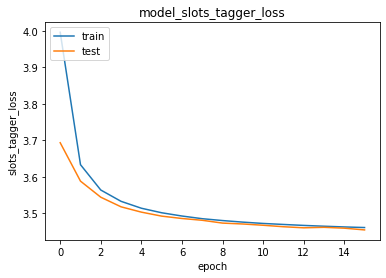

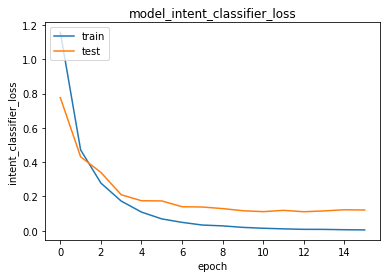

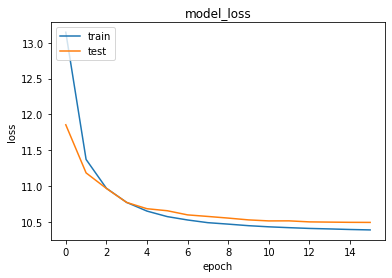

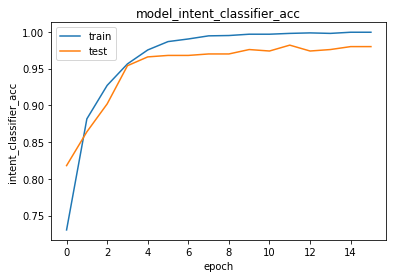

saving...
save


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import argparse
import tensorflow as tf
import pickle
import os

parser = argparse.ArgumentParser('Training the Joint Slot filling and Intent classification based on Bert')
parser.add_argument('--train', '-t', help='path to training data', type=str, required=True)
parser.add_argument('--val', '-v', help='path to validation data', type=str, required=True)
parser.add_argument('--save', '-s', help='folder path to save the trained model', type=str, required=True)
parser.add_argument('--epochs', '-e', help='number of epochs', type=int, default=5, required=False)
parser.add_argument('--batch_size', '-bs', help='batch size', type=int, default=64, required=False)

args = parser.parse_args('-t train -v val -s save'.split() )
train_data_folder_path =args.train
val_data_folder_path =args.val
save_folder_path =args.save
epochs =16
print(epochs)
batch_size =64

tf.compat.v1.random.set_random_seed(7)

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'

## import the dataset
train_text_arr, train_tags_arr, train_intents = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/atis/train') ## train dataset
val_text_arr, val_tags_arr, val_intents = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/atis/valid') ## validation dataset
print(train_text_arr)
# vectorize the train_text_arr and val_text_arr
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)
train_input_ids, train_input_mask, train_segment_ids, train_valid_positions, train_sequence_lengths = bert_vectorizer.transform(train_text_arr)
val_input_ids, val_input_mask, val_segment_ids, val_valid_positions, val_sequence_lengths = bert_vectorizer.transform(val_text_arr)

## vectorize the train_tags_arr and val_tags_arr
tags_vectorizer = TagsVectorizer()
tags_vectorizer.fit(train_tags_arr, val_tags_arr) ## use the train dataset to fit the tagsvectorizer
train_tags = tags_vectorizer.transform(train_tags_arr, train_valid_positions)
val_tags = tags_vectorizer.transform(val_tags_arr, val_valid_positions)
slots_num = len(tags_vectorizer.label_encoder.classes_)


## encode the intents label, directly by using the LabelEncoder library, which is provided by skeleran
intents_label_encoder = LabelEncoder()
### atis dataset is a little strange, because in val_dataset, there are tags and intents that don't exit in train_dataset
intents_label_encoder.fit(train_intents+val_intents)
train_intents = intents_label_encoder.transform(train_intents).astype(np.int64)

# ## we should use the train dataset to fit the label encoder and then return the encoded labels
# train_intents = intents_label_encoder.fit_transform(train_intents).astype(np.int32) ## fit_transform

val_intents = intents_label_encoder.transform(val_intents).astype(np.int64) ## transform
intents_num = len(intents_label_encoder.classes_)
print(intents_num)

model = JointBertModel(slots_num, intents_num, sess, num_bert_fine_tune_layers=12)
model.fit([train_input_ids, train_input_mask, train_segment_ids, train_valid_positions], [train_tags, train_intents],
          validation_data=([val_input_ids, val_input_mask, val_segment_ids, val_valid_positions], [val_tags, val_intents]),
          epochs=epochs, batch_size=batch_size)

## saving
print('saving...')
print(save_folder_path)
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)
    print('Folder "%s" created' % save_folder_path)
model.save(save_folder_path)

with open(os.path.join(save_folder_path, 'tags_vectorizer.pkl'), 'wb') as handle:
    pickle.dump(tags_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(save_folder_path, 'intents_label_encoder.pkl'), 'wb') as handle:
    pickle.dump(intents_label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

tf.compat.v1.reset_default_graph()

In [ ]:
print(train_tags)

[[121. 120. 120. ...   0.   0.   0.]
 [121.  63. 112. ...   0.   0.   0.]
 [121. 120. 120. ...   0.   0.   0.]
 ...
 [121. 120. 120. ...   0.   0.   0.]
 [121. 120.   0. ...   0.   0.   0.]
 [121. 120. 120. ...   0.   0.   0.]]


In [ ]:
from itertools import chain
import argparse
import os
import pickle
from sklearn import metrics
import json

parser = argparse.ArgumentParser('Evaluating the Joint BERT model')
parser.add_argument('--model', '-m', help='path to joint bert model', type=str, required=True)
parser.add_argument('--data', '-d', help='path to test data', type=str, required=True)
parser.add_argument('--batch', '-bs', help='batch size', type=int, default=128, required=False)
parser.add_argument('--pre_intents', '-pre_is', help='teh file name of saving predicted intents', type=str, required=True)
parser.add_argument('--pre_slots', '-pre_sls', help='the file name of saving predicted slots/tags', type=str, required=True)

args = parser.parse_args('-m model -d data -pre_is pre_intents -pre_sls pre_slots'.split())
load_folder_path = args.model
data_folder_path = args.data
batch_size =128
pre_intens_name = args.pre_intents
pre_slots_name = args.pre_slots

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)

## loading the model
print('Loading models ....')
if not os.path.exists('/content/save'):
    print('Folder "%s" not exist' % load_folder_path)

with open(os.path.join('/content/save', 'tags_vectorizer.pkl'), 'rb') as handle:
    tags_vectorizer = pickle.load(handle)
    slots_num = len(tags_vectorizer.label_encoder.classes_)
    print(tags_vectorizer.label_encoder.classes_)
with open(os.path.join('/content/save', 'intents_label_encoder.pkl'), 'rb') as handle:
    intents_label_encoder = pickle.load(handle)
    intents_num = len(intents_label_encoder.classes_)
    print(intents_label_encoder.classes_)
model = JointBertModel.load('/content/save', sess)

data_text_arr, data_tags_arr, data_intents = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/atis/test')
data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths = bert_vectorizer.transform(data_text_arr)


def flatten(y):
    ## flatten a list of lists.
    ## flatten([[1,2], [3,4]]) --> [1, 2, 3, 4]
    return list(chain.from_iterable(y))

def get_results(input_ids, input_mask, segment_ids, valid_positions, sequence_lengths, tags_arr, intents, tags_vectorizer, intents_label_encoder):
    predicted_tags, predicted_intents = model.predict_slots_intent(
        [input_ids, input_mask, segment_ids, valid_positions],
        tags_vectorizer, intents_label_encoder, remove_start_end=True
    )
    real_tags = [x.split() for x in tags_arr]

    f1_score = metrics.f1_score(flatten(real_tags), flatten(predicted_tags), average='micro')
    acc = metrics.accuracy_score(intents, predicted_intents)
    return f1_score, acc, predicted_intents, predicted_tags


print('.....Evaluation....')
f1_score, acc, predicted_intents, predicted_tags = get_results(data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths,
                            data_tags_arr, data_intents, tags_vectorizer, intents_label_encoder)


### print(type(predicted_tags)) ## <class 'numpy.ndarray'>
### save the predicted slots to file
with open(os.path.join('/content/save', pre_slots_name), 'w') as fp:
    for item in predicted_tags:
        #print(item)
        fp.write(" ".join(item) + "\n")
    fp.close()

### print(type(predicted_intents)) ## <class 'numpy.ndarray'>
### save the predicted intents to file
with open(os.path.join('/content/save', pre_intens_name), 'w') as fp:
    for item in predicted_intents:
        #print(item)
        fp.write("".join(map(str, item)))
    fp.close()

print('Slot f1 score = %f' % f1_score)
print('Intent accuracy = %f' % acc)


### save the f1 score and accuracy to file
eva_results = {
    "slots_f1_score" : f1_score,
    "intent_accuracy" : acc
}
with open(os.path.join('/content/save', "eva_results.json"), 'w') as json_file:
    json.dump(eva_results, json_file)

tf.compat.v1.reset_default_graph()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1
Loading models ....
['B-aircraft_code' 'B-airline_code' 'B-airline_name' 'B-airport_code'
 'B-airport_name' 'B-arrive_date.date_relative' 'B-arrive_date.day_name'
 'B-arrive_date.day_number' 'B-arrive_date.month_name'
 'B-arrive_date.today_relative' 'B-arrive_time.end_time'
 'B-arrive_time.period_mod' 'B-arrive_time.period_of_day'
 'B-arrive_time.start_time' 'B-arrive_time.time'
 'B-arrive_time.time_relative' 'B-city_name' 'B-class_type' 'B-connect'
 'B-cost_relative' 'B-day_name' 'B-day_number' 'B-days_code'
 'B-depart_date.date_relative' 'B-depart_date.day_name'
 'B-depart_date.day_number' 'B-depart_date.month_name'
 'B-depart_date.today_relative' 'B-depart_date.year'
 'B-depart_time.end_time' 'B-depart_time.period_mod'
 'B-depart_time.period_of_day' 'B-depart_time.start_time'
 'B-depart_time.time' 'B-depart_time.time_relative' 'B-economy'
 'B-fare_amount' 'B-fare_basis_code' 'B-flight_days' 'B-flight_mod'
 'B-flight_number' 'B-

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 124)]  0                                            
______________________________________________________________________________________________

In [ ]:
print(data_text_arr[0])
print(predicted_intents[0])
print(data_tags_arr[0])
print(data_intents[0])
print(predicted_tags[0])

i would like to find a flight from charlotte to las vegas that makes a stop in st. louis

atis_flight

O O O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O O O O O B-stoploc.city_name I-stoploc.city_name

atis_flight

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name']


In [ ]:
from itertools import chain
import argparse
import os
import pickle
from sklearn import metrics
import json

parser = argparse.ArgumentParser('Evaluating the Joint BERT model')
parser.add_argument('--model', '-m', help='path to joint bert model', type=str, required=True)
parser.add_argument('--data', '-d', help='path to test data', type=str, required=True)
parser.add_argument('--batch', '-bs', help='batch size', type=int, default=128, required=False)
parser.add_argument('--pre_intents', '-pre_is', help='teh file name of saving predicted intents', type=str, required=True)
parser.add_argument('--pre_slots', '-pre_sls', help='the file name of saving predicted slots/tags', type=str, required=True)

args = parser.parse_args('-m model -d data -pre_is pre_intents -pre_sls pre_slots'.split())
load_folder_path = args.model
data_folder_path = args.data
batch_size =128
pre_intens_name = args.pre_intents
pre_slots_name = args.pre_slots

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)

## loading the model
print('Loading models ....')
if not os.path.exists('/content/save'):
    print('Folder "%s" not exist' % load_folder_path)

with open(os.path.join('/content/save', 'tags_vectorizer.pkl'), 'rb') as handle:
    tags_vectorizer = pickle.load(handle)
    slots_num = len(tags_vectorizer.label_encoder.classes_)
    print(tags_vectorizer.label_encoder.classes_)
with open(os.path.join('/content/save', 'intents_label_encoder.pkl'), 'rb') as handle:
    intents_label_encoder = pickle.load(handle)
    intents_num = len(intents_label_encoder.classes_)
    print(intents_label_encoder.classes_)
model = JointBertModel.load('/content/save', sess)

data_text_arr, data_tags_arr, data_intents = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/atis/valid')
data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths = bert_vectorizer.transform(data_text_arr)


def flatten(y):
    ## flatten a list of lists.
    ## flatten([[1,2], [3,4]]) --> [1, 2, 3, 4]
    return list(chain.from_iterable(y))

def get_results(input_ids, input_mask, segment_ids, valid_positions, sequence_lengths, tags_arr, intents, tags_vectorizer, intents_label_encoder):
    predicted_tags, predicted_intents = model.predict_slots_intent(
        [input_ids, input_mask, segment_ids, valid_positions],
        tags_vectorizer, intents_label_encoder, remove_start_end=True
    )
    real_tags = [x.split() for x in tags_arr]

    f1_score = metrics.f1_score(flatten(real_tags), flatten(predicted_tags), average='micro')
    acc = metrics.accuracy_score(intents, predicted_intents)
    return f1_score, acc, predicted_intents, predicted_tags


print('.....Evaluation....')
f1_score, acc, predicted_intents, predicted_tags = get_results(data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths,
                            data_tags_arr, data_intents, tags_vectorizer, intents_label_encoder)


### print(type(predicted_tags)) ## <class 'numpy.ndarray'>
### save the predicted slots to file
with open(os.path.join('/content/save', pre_slots_name), 'w') as fp:
    for item in predicted_tags:
        #print(item)
        fp.write(" ".join(item) + "\n")
    fp.close()

### print(type(predicted_intents)) ## <class 'numpy.ndarray'>
### save the predicted intents to file
with open(os.path.join('/content/save', pre_intens_name), 'w') as fp:
    for item in predicted_intents:
        #print(item)
        fp.write("".join(map(str, item)))
    fp.close()

print('Slot f1 score = %f' % f1_score)
print('Intent accuracy = %f' % acc)


### save the f1 score and accuracy to file
eva_results = {
    "slots_f1_score" : f1_score,
    "intent_accuracy" : acc
}
with open(os.path.join('/content/save', "eva_results.json"), 'w') as json_file:
    json.dump(eva_results, json_file)

tf.compat.v1.reset_default_graph()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1
Loading models ....
['B-aircraft_code' 'B-airline_code' 'B-airline_name' 'B-airport_code'
 'B-airport_name' 'B-arrive_date.date_relative' 'B-arrive_date.day_name'
 'B-arrive_date.day_number' 'B-arrive_date.month_name'
 'B-arrive_date.today_relative' 'B-arrive_time.end_time'
 'B-arrive_time.period_mod' 'B-arrive_time.period_of_day'
 'B-arrive_time.start_time' 'B-arrive_time.time'
 'B-arrive_time.time_relative' 'B-city_name' 'B-class_type' 'B-connect'
 'B-cost_relative' 'B-day_name' 'B-day_number' 'B-days_code'
 'B-depart_date.date_relative' 'B-depart_date.day_name'
 'B-depart_date.day_number' 'B-depart_date.month_name'
 'B-depart_date.today_relative' 'B-depart_date.year'
 'B-depart_time.end_time' 'B-depart_time.period_mod'
 'B-depart_time.period_of_day' 'B-depart_time.start_time'
 'B-depart_time.time' 'B-depart_time.time_relative' 'B-economy'
 'B-fare_amount' 'B-fare_basis_code' 'B-flight_days' 'B-flight_mod'
 'B-flight_number' 'B-

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 124)]  0                                            
______________________________________________________________________________________________